In [1]:
from brian2 import*
import matplotlib.pyplot as plt
import numpy as np
import sympy
import plotutils as pu

WARNING    Cannot use Cython, a test compilation failed: command 'cl.exe' failed: No such file or directory (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Text(0.5, 1.0, 'Spiking activity of Inhibitatory')

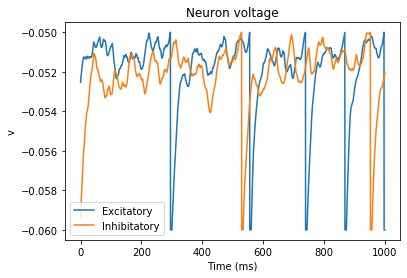

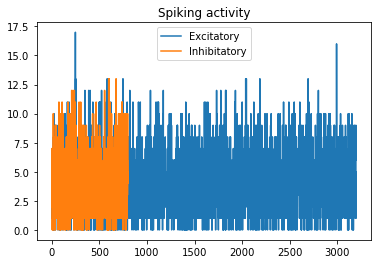

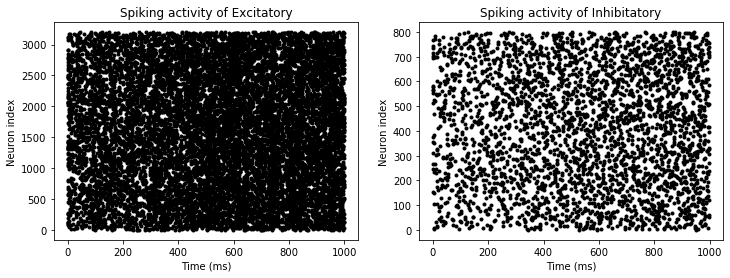

In [2]:
seed(11922)  # to get identical figures for repeated runs

################################################################################
# Model parameters
################################################################################
### General parameters
duration = 1.0*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_e = 3200             # Number of excitatory neurons
N_i = 800              # Number of inhibitory neurons

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 9.99*nS          # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -80*mV           # Inhibitory synaptic reversal potential
C_m = 198*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 10*ms          # Inhibitory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 150*pA          # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
w_i = 1.0*nS           # Inhibitory synaptic conductance
U_0 = 0.6              # Synaptic release probability at rest
Omega_d = 2.0/second   # Synaptic depression rate
Omega_f = 3.33/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic inh. conductance
'''
neurons = NeuronGroup(N_e + N_i, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
neurons.v = 'E_l + rand()*(V_th-E_l)'
neurons.g_e = 'rand()*w_e'
neurons.g_i = 'rand()*w_i'
exc_neurons = neurons[:N_e]
inh_neurons = neurons[N_e:]

### Synapses
synapses_eqs = '''
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(exc_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S')
inh_syn = Synapses(inh_neurons, neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S')

exc_syn.connect(p=0.05)
inh_syn.connect(p=0.2)
# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources
exc_syn.x_S = 1
inh_syn.x_S = 1

# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)
inh_mon = SpikeMonitor(inh_neurons)

M = StateMonitor(neurons, variables = 'v', record = True)
net = Network(neurons, exc_syn, inh_syn, exc_mon, inh_mon, M)
net.store()

# ##############################################################################
# # Simulation run
# ##############################################################################
net.run(duration)

fig = figure(1)
plot(M.t/ms, M.v[0], label = 'Excitatory')
plot(M.t/ms, M.v[N_e+1], label = 'Inhibitatory')
legend()
xlabel('Time (ms)')
ylabel('v')
plt.title("Neuron voltage")

figure(2)
plot(range(N_e), exc_mon.count/duration, label = 'Excitatory')
plot(range(N_i), inh_mon.count/duration, label = 'Inhibitatory')
legend()
plt.title("Spiking activity")


figure(figsize=(12,4))
subplot(121)
plot(exc_mon.t/ms, exc_mon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
plt.title('Spiking activity of Excitatory')

subplot(122)
plot(inh_mon.t/ms, inh_mon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
plt.title('Spiking activity of Inhibitatory')